In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# ensure that any edits to libraries you make are reloaded here automatically,
# and also that any charts or images displayed are shown in this notebook.


import numpy as np
import scipy as sc
import sklearn as sk
from sklearn import datasets, linear_model, model_selection, metrics
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib as mpl
np.set_printoptions(precision=2)
plt.rcParams['figure.figsize'] = [12, 8]


import torch
import torch.nn as nn

import compare_models_functions as myfxns


cases_df, deaths_df = myfxns.load_county_datasets()



In [2]:
# LSTM, treating counties as independent
# TODO try passing in differences instead of raw counts

from sklearn.preprocessing import MinMaxScaler

import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

from torch.utils.data import DataLoader




class SeqDataset(torch.utils.data.Dataset):
    '''dataset that optionally maintains list of IDs for each sample (e.g. county name or fips).
    inputs, labels, and list_IDs must be in same order'''
    def __init__(self, inputs, labels, has_header_col=False):
        'Initialization'

        self.inputs = inputs # assume 2D array, each row is sample
        self.labels = labels # assume 2D, each row is sample

        self.list_IDs = ['no_id' for i in range(self.inputs.shape[0])]
            
        if has_header_col: # if inputs has header col
            self.list_IDs = inputs[:,0]
            self.inputs = inputs[:,1:]
        
  
    def __len__(self):
        'Denotes the total number of samples'
        return self.inputs.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        
        sample_id = self.list_IDs[index]
        X = self.inputs[index,:]
        y = self.labels[index,:]

        return X, y, sample_id
    
    # could add option to look up ID of a datapoint, and make inputs and labels dictionary
    #ID = self.list_IDs[index]
    


# inputs small, try varying batch size
#input_dim = 1 # number of features per timepoint/token
#input_seq_len = 21 # length of input sequence/series

def train_lstm(train_dataset, batch_size=100, num_epochs=10, lr=0.05, 
               input_dim=1, hidden_dim=21, pred_seq_len=7):
    '''simple train function w batches w/o early stopping or checkpoints'''
    
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, 
                              num_workers = 4, drop_last = True)
    # TODO handle batches which aren't multiple of whole dataset, currently drop, could pad


    model = LSTM(input_dim, hidden_dim, output_dim=pred_seq_len, batch_size=batch_size, num_layers=2, dropout=0.5)
    model = model.to(DEVICE)
    model = model.train()
    model = model.double() # set model to use double, otherwise float vs double error
    
    criterion = torch.nn.MSELoss() #L1Loss()    # for regression
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) # can try other optimizer

    #num_batches = int(len(train_dataset) / float(batch_size)) + 1
    

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get batch
            inputs, labels, sample_id = data[0].to(DEVICE), data[1].to(DEVICE), data[2]
                        
            # zero the parameter gradients
            optimizer.zero_grad()
            model.reset_hidden() # also reset hidden state

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # update loss
            running_loss += loss.item()

        #End of epoch report
        if epoch % 1 == 0:
            print('[Epoch %d] loss: %.3f' %
                  (epoch + 1, running_loss )) 
            # TODO get per item loss, porb fine since each epoch train same size

    print('Finished Training')
    
    return model


class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size=1, output_dim=1,
                    num_layers=10, dropout=0.2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim   # how many features per time point (or token)
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.output_dim = output_dim

        # lstm layers and linear layer to output single time point
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, 
                            dropout=self.dropout, batch_first=True)
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)
 
    def reset_hidden(self): # use to reset hidden state
        self.hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    

    def forward(self, inputs):
        # note: dim depends on whether lstm layer initialized with batch_first. 
        # Code assumes batch_first, unidirectional
        
        # nn.LSTM expects input shape ( timepoints, batch_size, features per timepoint)
        #        or (batch_size, timepoints, features per timepoint) if batch_first
        # lstm_out: (seq_len, batch, num_directions * hidden_size) 
        #        or (batch, seq_len, numdir*hidden_size)
        # self.hidden: tup of two (num_layers, batch_size, hidden_dim)
        #                     or (batch_size, num_layers, hidden_dim)
        lstm_out, self.hidden = self.lstm(inputs.view(self.batch_size, -1, self.input_dim)) 

        # linear layer takes output of final timestep
        # TODO should it take output or hidden?
        y_pred = self.linear(lstm_out[:,-1,:])
        return y_pred


In [13]:
## train LSTM: here using one sample per county, outputting next week all at once

# preprocess data
# only use 28 days, and use all counties with 28 days
X_df, X, y = myfxns.filter_and_scale_data(cases_df, cases_or_deaths = 'cases', 
    use_last_n_days=28,  max_frac_missing=0.0, 
    use_rel_counts=False, use_log_counts = True, use_counts_only = True)

#X = np.array(X_df.iloc[:,3:]) # each row county, each col is counts for 28 days
X = np.array(  X_df.drop(['county', 'state'], axis=1) ) 
# Note: in X, keep fips as first column, convert to sample id in dataloader

# split data (currently split into train/test counties, but could split into train/test days or both)
Xtrain, Xtest = model_selection.train_test_split(X, test_size=0.25)

pred_seq_len = 7
Xtrain_inputs = Xtrain[:,:-pred_seq_len]
Xtrain_labels = Xtrain[:,-pred_seq_len:] # predict last 7 days
Xtest_inputs = Xtest[:,:-pred_seq_len]
Xtest_labels = Xtest[:,-pred_seq_len:]

'''
# normalize inputs (best practice for lstm)
# didn't seem to make much difference, so omitted for now
# can expt here, larger values may be seen in latest samples so not sure if appropriate
scaler = MinMaxScaler()
scaler = scaler.fit(Xtrain_inputs)
Xtrain_inputs = scaler.transform(Xtrain_inputs)
Xtest_inputs = scaler.transform(Xtest_inputs)
'''

DEVICE = torch.device('cuda') # 'cpu')
print('Using device: ' + str(DEVICE))

train_dataset = SeqDataset(Xtrain_inputs, Xtrain_labels, has_header_col=True)
batch_size=30
model = train_lstm(train_dataset, num_epochs=30, batch_size=batch_size,lr=0.02, pred_seq_len = pred_seq_len)




Using device: cuda
[Epoch 1] loss: 469.387
[Epoch 2] loss: 114.477
[Epoch 3] loss: 43.173
[Epoch 4] loss: 24.406
[Epoch 5] loss: 20.859
[Epoch 6] loss: 17.465
[Epoch 7] loss: 14.193
[Epoch 8] loss: 13.511
[Epoch 9] loss: 9.818
[Epoch 10] loss: 12.027
[Epoch 11] loss: 8.868
[Epoch 12] loss: 10.177
[Epoch 13] loss: 8.269
[Epoch 14] loss: 7.021
[Epoch 15] loss: 9.354
[Epoch 16] loss: 6.349
[Epoch 17] loss: 7.251
[Epoch 18] loss: 7.489
[Epoch 19] loss: 7.430
[Epoch 20] loss: 6.078
[Epoch 21] loss: 7.200
[Epoch 22] loss: 6.296
[Epoch 23] loss: 6.439
[Epoch 24] loss: 5.291
[Epoch 25] loss: 7.067
[Epoch 26] loss: 5.941
[Epoch 27] loss: 4.812
[Epoch 28] loss: 7.694
[Epoch 29] loss: 5.428
[Epoch 30] loss: 4.790
Finished Training


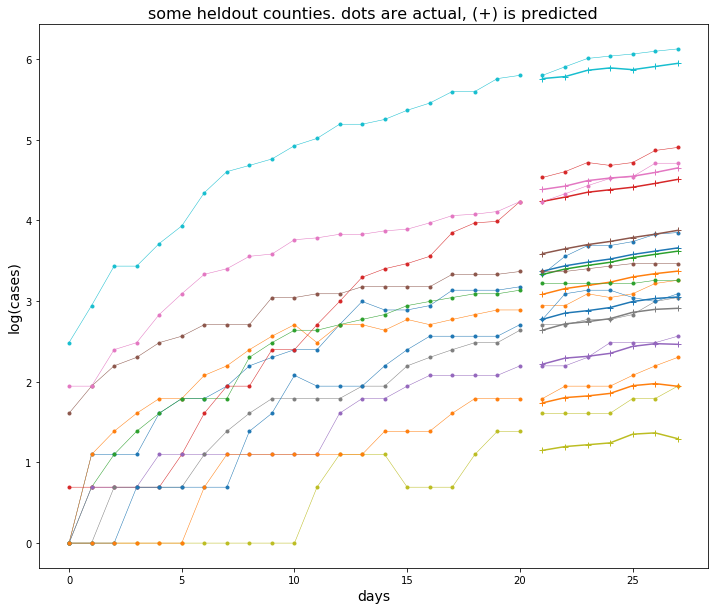

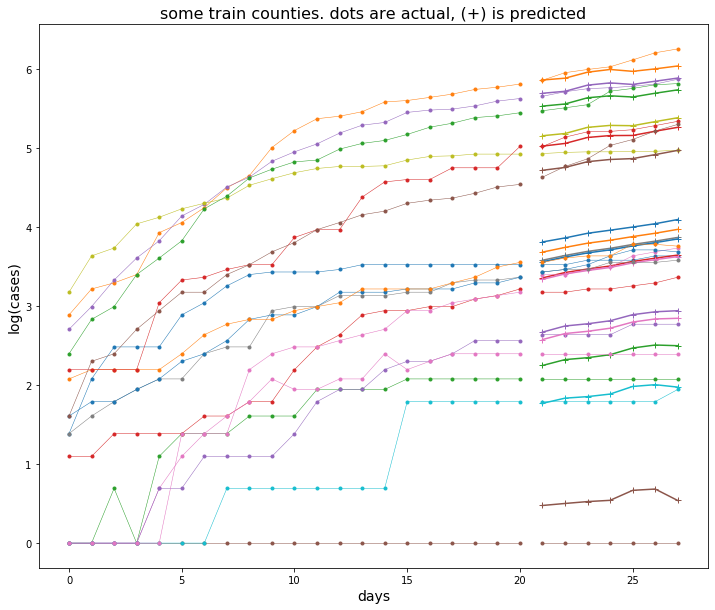

In [14]:
# predict on holdout counties, plot a few examples

model.reset_hidden()
model.double().to(DEVICE).eval()
#train_dataset = SeqDataset(Xtrain_inputs, Xtrain_labels, has_header_col=True)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False, 
                              num_workers = 4, drop_last = True)


test_dataset = SeqDataset(Xtest_inputs, Xtest_labels, has_header_col=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, 
                              num_workers = 4, drop_last = True)


fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(12,10))
ax.set_xlabel('days', size=14)
ax.set_ylabel('log(cases)', size=14)
ax.set_title('some heldout counties. dots are actual, (+) is predicted', size=16)

with torch.no_grad():
    for i, data in enumerate(test_loader, 0): # train_loader, 0):
        # only plot first sample from each batch, could also set batch_size 1 and pick subset
        # note: sample_id is fips, can use to make legend or print sample id, color if you like
        inputs, labels, sample_id = data[0].to(DEVICE), data[1].to(DEVICE), data[2]
        model.reset_hidden()
        preds = model(inputs.double()).detach().cpu().numpy()
        # remember to untransform inputs
        # TODO with torch.nograd prob easier
        inputs = inputs.detach().cpu().numpy() 
        #inputs = scaler.inverse_transform(inputs)
        labels = labels.detach().cpu().numpy()

        end_train = 28 - pred_seq_len
        p = ax.plot(range(end_train), inputs[0], marker='.', 
                    linewidth=0.5) # actual log(cases)
        color = p[0].get_color()
        end = 21+pred_seq_len
        ax.plot(range(end_train,28), labels[0], c=color, marker='.', linewidth=0.5) # actual log(cases), last week
        ax.plot(range(end_train, 28), preds[0], c=color, marker='+', linewidth=1.5) # pred log(cases), last week

        if i>15:
            break
    
plt.show()




#preds_train = []
#labels_train = []

fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(12,10))
ax.set_xlabel('days', size=14)
ax.set_ylabel('log(cases)', size=14)
ax.set_title('some train counties. dots are actual, (+) is predicted', size=16)

with torch.no_grad():
    for i, data in enumerate(train_loader, 0): # train_loader, 0):
        # only plot first sample from each batch
        inputs, labels, sample_id = data[0].to(DEVICE), data[1].to(DEVICE), data[2]
        model.reset_hidden()
        preds = model(inputs.double()).detach().cpu().numpy()
        # remember to untransform inputs
        inputs = inputs.detach().cpu().numpy()
        #inputs = scaler.inverse_transform(inputs)
        labels = labels.detach().cpu().numpy()

        end_train = 28 - pred_seq_len
        p = ax.plot(range(end_train), inputs[0],marker='.', linewidth=0.5) # actual log(cases)
        color = p[0].get_color()
        end = 21+pred_seq_len
        ax.plot(range(end_train,28), labels[0], c=color, marker='.', linewidth=0.5) # actual log(cases), last week
        ax.plot(range(end_train, 28), preds[0], c=color, marker='+', linewidth=1.5) # pred log(cases), last week

        if i>15:
            break

    plt.show()


In [8]:
## note: counties can have decreasing cases from day to day, ex/ fips 05011

print('Example of decreasing case or log(case)) counts:')
# Bradley county, april 4 to april 5
print(X_df[X_df['fips'] == 5011].iloc[:,0:3])
print(X_df[X_df['fips'] == 5011].iloc[:,-25:-16])




Example of decreasing case or log(case)) counts:
       fips   county     state
100  5011.0  Bradley  Arkansas
     2020-03-28 00:00:00  2020-03-29 00:00:00  2020-03-30 00:00:00  \
100             1.386294             1.386294             1.386294   

     2020-03-31 00:00:00  2020-04-01 00:00:00  2020-04-02 00:00:00  \
100             1.386294             1.386294             1.386294   

     2020-04-03 00:00:00  2020-04-04 00:00:00  2020-04-05 00:00:00  
100             1.386294             1.386294                  0.0  


In [19]:
## now train on sliding windows (multiple windows per county)
# hold out last 7 days for test


def sliding_windows(data, seq_length):
    '''given 1D arr of timepoints, return array of sliding windows (x) 
    and value immediately following (y)'''
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)


# filter data - only use 28 days, and use all counties with 28 days
X_df, X, y = myfxns.filter_and_scale_data(cases_df, cases_or_deaths = 'cases', 
    use_last_n_days=28,  max_frac_missing=0.0, 
    use_rel_counts=False, use_log_counts = True, use_counts_only = True)

X = np.array(  X_df.drop(['county', 'state'], axis=1) ) 
# Note: in X, keep fips as first column, convert to sample id in dataloader
Xtrain = X[:,:-7]
Xtest = np.empty((X.shape[0], 8))
Xtest[:,0] = X[:,0] # fips
Xtest[:,-7:] = X[:,-7:]

# generate sliding windows to train on, each sample will be [fips, ct1, ..., ct14, ct15]

input_seq_len = 14   # use past 2 weeks to predict next day
# total number of samples will be num counties * num windows for each
num_counties = Xtrain.shape[0]
num_dates = Xtrain.shape[1] - 1 # don't include fips
num_windows = num_dates - input_seq_len - 1 # num windows per county

# data_sliding contains [fips, ct1, ..., ct14, ct15] for input seq len 0
# fips is col 0, middle is input seq, target is last col
slide_train = -1*np.ones((num_counties*num_windows, input_seq_len + 2))

for i in range(Xtrain.shape[0]):
    x, y = sliding_windows(Xtrain[i,1:], input_seq_len)
    fips_i = X[i,0]
    rows_i = tuple(range((i*num_windows),((i+1)*num_windows)))
    slide_train[rows_i,0] = fips_i
    slide_train[rows_i,1:-1] = x
    slide_train[rows_i,-1] = y
print('made sliding windows for training')

    
# now train on sliding windows, predict only 1 day into future
DEVICE = torch.device('cuda') # use 'cpu' for debug, 'cuda' for run on gpu
print('Using device: ' + str(DEVICE))

# if you want validation set or hold out sequences for testing
#slide_train, slide_valid = model_selection.train_test_split(data_sliding, test_size=0.2)


# note: labels should be a 2D array, reshape TODO not using all train data rn
train_dataset = SeqDataset(slide_train[:,:-1], slide_train[:,-1].reshape((-1,1)), has_header_col=True)
batch_size=100
slide_model = train_lstm(train_dataset, num_epochs=20, batch_size=batch_size, lr=0.05, pred_seq_len = 1)




made sliding windows for training
Using device: cuda
[Epoch 1] loss: 141.714
[Epoch 2] loss: 36.411
[Epoch 3] loss: 20.796
[Epoch 4] loss: 19.343
[Epoch 5] loss: 14.371
[Epoch 6] loss: 11.772
[Epoch 7] loss: 10.564
[Epoch 8] loss: 10.730
[Epoch 9] loss: 9.355
[Epoch 10] loss: 8.485
[Epoch 11] loss: 9.614
[Epoch 12] loss: 7.605
[Epoch 13] loss: 7.540
[Epoch 14] loss: 7.907
[Epoch 15] loss: 7.078
[Epoch 16] loss: 6.992
[Epoch 17] loss: 7.257
[Epoch 18] loss: 5.717
[Epoch 19] loss: 7.935
[Epoch 20] loss: 5.870
Finished Training


In [64]:
# predict held-out 7 days, using model trained on sliding windows

# i did not scale training data, but use inverse_transform if scaled
slide_model.reset_hidden()
slide_model.eval().cpu().double()
slide_model.batch_size = 1 # if want to run on one sample at a time


preds = np.copy(X) # first col fips
preds[:,-7:] = -1  # last 7 cols of preds will be predictions

preds_dataset = SeqDataset(preds, preds, has_header_col=True)
county_loader = DataLoader(preds_dataset, batch_size = 1, shuffle = False, 
                              num_workers = 4, drop_last = True)

# TODO this could be easily done in a large batch at a time. dataset small so doesn't matter much, takes a min
with torch.no_grad():
    for i, data in enumerate(county_loader, 0):
        data_i, dummy_labels, fips = data[0], data[1], data[2]
        
        for j in range(7,0,-1):
            input_seq = data_i[:,-(j+15):-(j+1)].double() # pass in prev 14 days
            slide_model.reset_hidden()
            next_day_pred = slide_model(input_seq).item() # pred next day
            data_i[0,-j] = next_day_pred
            preds[i,-j] = next_day_pred
            # could also try pred based on preceding day and hidden state
            #prev_day = torch.Tensor([[prev_day]]).double()
            #preds[i,-(j+1)] = slide_model(input_seq).item() 

            

print(X[0:1000:100, -7:])
print(preds[0:1000:100, -7:])


[[3.22 3.22 3.26 3.22 3.3  3.33 3.4 ]
 [6.42 6.45 6.47 6.53 6.54 6.56 6.62]
 [6.61 6.65 6.71 6.73 6.75 6.8  6.81]
 [5.2  5.3  5.35 5.38 5.41 5.43 5.46]
 [1.39 1.39 1.39 1.61 1.61 1.61 1.61]
 [2.89 2.89 2.89 2.89 2.89 2.89 2.94]
 [7.83 7.91 7.99 8.06 8.12 8.18 8.23]
 [3.93 3.99 4.03 4.04 4.11 4.11 4.11]
 [1.39 1.39 1.39 1.39 1.39 1.39 1.39]
 [3.43 3.47 3.53 3.61 3.66 3.66 3.66]]
[[3.13 3.23 3.29 3.36 3.44 3.51 3.58]
 [6.7  6.77 6.89 6.98 7.07 7.15 7.23]
 [6.87 6.95 7.06 7.15 7.23 7.3  7.37]
 [5.2  5.27 5.33 5.4  5.47 5.54 5.61]
 [1.59 1.59 1.68 1.75 1.82 1.89 1.96]
 [3.04 3.07 3.16 3.22 3.29 3.36 3.44]
 [7.6  7.71 7.79 7.9  8.02 8.16 8.3 ]
 [3.57 3.6  3.7  3.77 3.85 3.93 4.01]
 [1.59 1.59 1.68 1.75 1.82 1.89 1.96]
 [3.62 3.64 3.74 3.81 3.89 3.97 4.05]]


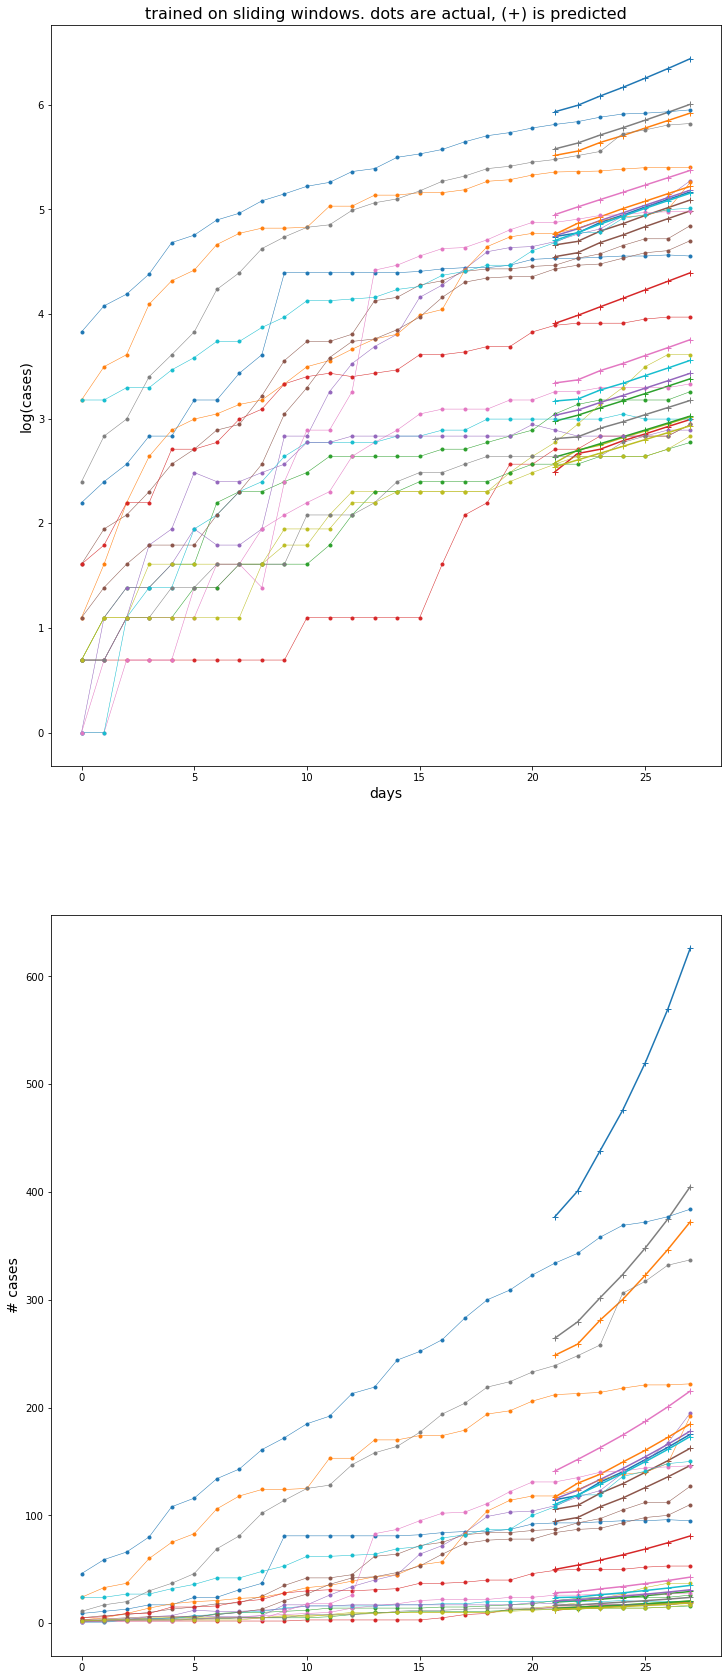

fips shown: [47141. 21067.  2110. 51147.  1095. 37051. 47073. 25015. 39043. 55017.
 20091. 40147. 54079. 28045. 29043.  1055. 13243. 45073. 13195.  6053.]


In [71]:
## plot some predictions from sliding window model

fig, axs = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(12,30))
axs[0].set_xlabel('days', size=14)
axs[0].set_ylabel('log(cases)', size=14)
axs[1].set_ylabel('# cases', size=14)

axs[0].set_title('trained on sliding windows. dots are actual, (+) is predicted', size=16)


# now, X contains fips and true data
# preds contains fips, and last 7 cols are predictions

# select random subset of counties to plot
idxs = np.random.choice(range(preds.shape[0]), size=(20,))

for i in idxs:
    # plot actual log(cases)
    p = axs[0].plot(range(28), X[i,1:], marker='.', linewidth=0.5)
    color = p[0].get_color()
    
    # plot pred log(cases)
    axs[0].plot(range(21,28), preds[i,-7:], marker='+', c=color)
    
    # plot actual cases
    axs[1].plot(range(28), np.exp(X[i,1:]), marker='.', linewidth=0.5)

    # plot pred cases
    axs[1].plot(range(21,28), np.exp(preds[i,-7:]), marker='+', c=color)


plt.show()
print('fips shown:', X[idxs,0])
    
    


In [ ]:
# TODO predict cases and deaths simultaneously
# TODO pass in exogenous data for each county
# maybe predict multiple counties simultaneously (no new counties, wouldn't work for holdout set of counties tho)

In [ ]:
# TODO arima using other counties, deaths, state-level testing as exogenous 

# TODO add proportion or number tested as feature
# state-level data available here, including time series starting from feb 28:
# https://covidtracking.com/data

# TODO will output predictions from ARIMA and LSTM models in the prediction_csv/ directory
